In [2]:
# -*- coding: utf-8 -*-
"""
Created on Thu Mar 17

@author: Yubin Hu

修改：
1.删减相互相关的特征
2.增加了归一化

目前score在0.6左右

需要：
1.测试经纬度用距离替换效果
2.加权测试

"""

#可视化函数
def viz(title,x,y,viz_flag):
    if(viz_flag==1):
        import matplotlib.pyplot as plt
        
        y_predict=x
        y_test=y
        score=title
    #    string='security_deposit'
    #    plt.scatter(AirbnbKNN_y,house_features[string])
    #    plt.xlabel("Nightly Price")
    #    plt.ylabel(string.replace('_', ' ')) 
        
        plt.scatter(y_predict,y_test)
        plt.xlabel("Predict")
        plt.ylabel("Correct") 
        plt.title("score is "+str(score))
        ##string='accommodates'
        ##plt.scatter(AirbnbKNN_y,house_features[string])
        ##plt.xlabel("Nightly Price")
        ##plt.ylabel(string.replace('_', ' ')) #数据预处理,去掉逗号
    
        plt.show()
    if(viz_flag==2):
        import matplotlib.pyplot as plt
        plt.hist(x,bins=40)
        plt.xlabel("Score")
        plt.ylabel("Frequency")
        plt.title("The average score is "+str(title))

#读入数据
import pandas as pd
import numpy as np
dc_listings=pd.read_csv("dc_airbnb-filtered.csv")

#print(dc_listings.iloc[2072])
#dc_listings.drop([2072], inplace = True) #此行数据KNN不擅长预测


#数据预处理
stripped_commas = dc_listings['price'].str.replace(',', '') #数据预处理,去掉逗号
stripped_dollars = stripped_commas.str.replace('$', '') #数据预处理，去掉美金符号
dc_listings['price'] = stripped_dollars.astype('float') #数据预处理，强制转换为float类型
dc_listings['host_response_rate'] = dc_listings['host_response_rate'].str.replace('%', '') #数据预处理，去掉百分号
dc_listings['host_acceptance_rate'] = dc_listings['host_acceptance_rate'].str.replace('%', '')
stripped_commas = dc_listings['cleaning_fee'].str.replace(',', '') #数据预处理,去掉逗号
stripped_dollars = stripped_commas.str.replace('$', '') #数据预处理，去掉美金符号
stripped_spaces = stripped_dollars.str.replace(' ','') #数据预处理，去掉空格
dc_listings['cleaning_fee'] = stripped_spaces
stripped_commas = dc_listings['security_deposit'].str.replace(',', '') #数据预处理,去掉逗号
stripped_dollars = stripped_commas.str.replace('$', '') #数据预处理，去掉美金符号
stripped_spaces = stripped_dollars.str.replace(' ','')
dc_listings['security_deposit'] = stripped_spaces
dc_listings['room_type'] = dc_listings['room_type'].str.replace('Entire home/apt', '3') #数据预处理,赋值，entire 3， private 2， shared 1
dc_listings['room_type'] = dc_listings['room_type'].str.replace('Private room', '2')
dc_listings['room_type'] = dc_listings['room_type'].str.replace('Shared room', '1')
dc_listings['host_listings_count'] = dc_listings['host_listings_count'].astype('float')
dc_listings['accommodates'] = dc_listings['accommodates'].astype('float')
dc_listings['beds'] = dc_listings['beds'].astype('float')
dc_listings['maximum_nights'] = dc_listings['maximum_nights'].astype('float')
dc_listings['cleaning_fee'] = dc_listings['cleaning_fee'].astype('float')
dc_listings['security_deposit'] = dc_listings['security_deposit'].astype('float')
dc_listings['room_type'] = dc_listings['room_type'].astype('float')
dc_listings['host_response_rate'] = dc_listings['host_response_rate'].astype('float')
dc_listings['host_acceptance_rate'] = dc_listings['host_acceptance_rate'].astype('float')

#dc_listings = dc_listings.loc[np.random.permutation(len(dc_listings))] #对现有数列随机排列

accommodates           4.000000
room_type              3.000000
bedrooms               1.000000
bathrooms              1.000000
beds                   2.000000
cleaning_fee         115.000000
number_of_reviews      0.000000
latitude              38.890046
longitude            -77.002808
Name: 0, dtype: float64


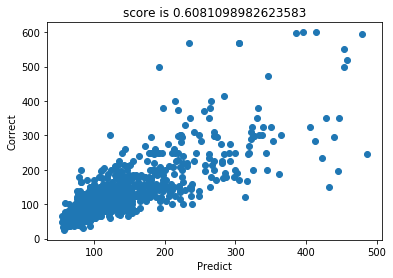

Trial: 200 times


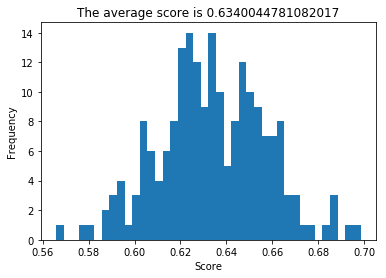

In [4]:
distance_flag=False #是否用离市中心距离替代经纬度
independent_flag=False #是否只保留相互独立的变量
response_flag=False #是否考虑 host_response_rate 和 host_acceptance_rate
review_flag=True #是否考虑 number_of_reviews
cleaning_fee_flag=True 
security_deposit_flag=False #insignificant
room_type_flag=True #significant yes
filter_flag=True #是否删除大于1000美元价格的房屋

def AirbnbKNN_score(dc_listings):
    #数据选择
    if(filter_flag==True):
        house_features=dc_listings[dc_listings.price<1000]
    else:
        house_features=dc_listings
    house_features=house_features.dropna(subset=['host_acceptance_rate']) #去除未成交房屋
    del house_features['city'] #去除重复信息
    del house_features['zipcode']
    del house_features['state']
    del house_features['minimum_nights']
    del house_features['maximum_nights']
    del house_features['host_listings_count']
    if(cleaning_fee_flag==False):
        del house_features['cleaning_fee']
    if(security_deposit_flag==False):
        del house_features['security_deposit']
    if(independent_flag==True):
        del house_features['bedrooms']
        del house_features['beds']
    if(response_flag==False):
        del house_features['host_response_rate']
        del house_features['host_acceptance_rate']
    if(review_flag==False):
        del house_features['number_of_reviews']
    if(room_type_flag==False):
        del house_features['room_type']

    #距离替换经纬度
    if(distance_flag==True):
        DC_capital_lat=38.889931
        DC_capital_long=-77.009003
        distance=((house_features['latitude']-DC_capital_lat)**2+(house_features['longitude']-DC_capital_long)**2)**0.5
        house_features['latitude']=distance
        del house_features['longitude']

    #产生KNN输入
    house_features=house_features.fillna(0) #补充 cleaning fee等列的nan
    AirbnbKNN_X = house_features 
    AirbnbKNN_y = np.array(house_features['price'])
    del AirbnbKNN_X['price']
    AirbnbKNN_X = np.array(AirbnbKNN_X)

    print(house_features.iloc[0])

    #归一化
    from sklearn import preprocessing
    min_max_scaler = preprocessing.MinMaxScaler()
    AirbnbKNN_X = min_max_scaler.fit_transform(AirbnbKNN_X)

    #数据切分，训练模型，用训练好的模型进行预测,并对预测好坏进行评估
    from sklearn.model_selection import train_test_split
    from sklearn.neighbors import KNeighborsRegressor
    knn = KNeighborsRegressor(n_neighbors=20) #定义用sklearn中的KNN分类算法 
    total_score=0.0
    trial_number=200
    score_list=[]
    for i in range(trial_number):
        X_train,X_test,y_train,y_test = train_test_split(AirbnbKNN_X,AirbnbKNN_y,test_size = 0.3)
        knn.fit(X_train,y_train)
        #print(knn.predict(X_test))   #这里的knn就是已经train好了的knn
        #print(y_test)    # 对比真实值
        score = knn.score(X_test,y_test)
        total_score += score
        score_list.append(score)
        if(i==0):
            viz(score,knn.predict(X_test),y_test,1)
    
    avg_score=total_score/trial_number
    viz(avg_score,score_list,y_test,2)
    print("Trial: "+str(trial_number)+" times")
AirbnbKNN_score(dc_listings)

# 用距市中心距离替代经纬度

In [1]:
distance_flag=True
AirbnbKNN_score(dc_listings)

NameError: name 'AirbnbKNN_score' is not defined

# 只保留相互独立的变量

accommodates           4.000000
room_type              3.000000
bathrooms              1.000000
cleaning_fee         115.000000
number_of_reviews      0.000000
latitude              38.890046
longitude            -77.002808
Name: 0, dtype: float64


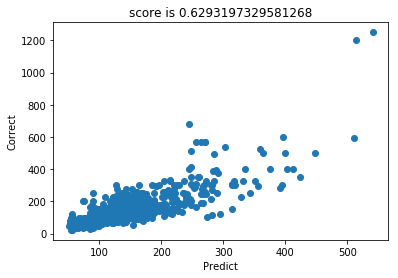

Trial: 200 times


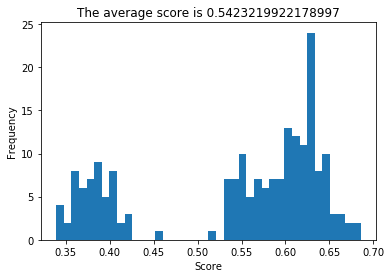

In [81]:
independent_flag=True #是否只保留相互独立的变量
AirbnbKNN_score(dc_listings)